In [1]:
!pip install -q fake-useragent

In [2]:
# Imports liés à la manipulation de données
import pandas as pd
import numpy as np
import random

# Imports pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Imports pour la gestion des avertissements
import warnings

# Imports liés à l'analyse de texte
import re

# Imports spécifiques à la création des entêtes
from fake_useragent import UserAgent
import time
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

plt.style.use('ggplot') #pour colorier les graphiques

np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore') #pour ignorer les warnings
pd.set_option('display.max_columns',10)

# 5.1 Collecte de données

In [3]:
#Cette fonction permet de lire le contenu d'une page
def getPages(arg=""):
  if str(arg).isnumeric() :
    url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,2018-12-31&start='+str(arg)+'&ref_=adv_nxt'
  else:
    url = arg
    
  user_agent = {'User-agent': UserAgent().random}
  page = requests.get(url, headers = user_agent).text

  # Attendre au moins 30 seconds
  sleep_time = 5 + 20 * random.random() #sleep_time = 28 + 20 * random.random()
  time.sleep(sleep_time)

  return page

In [4]:
#Cette fonction pour recuper le genre du film fourni en url
def getGenres(filmUrl):
    #"https://www.imdb.com//title/tt2709692/?ref_=sr_t_1"
    page = getPages(filmUrl)
    soup = BeautifulSoup(page, "html.parser")
    filmGenres = soup.find("div", {"class": "ipc-chip-list__scroller"})
    genres = filmGenres.find_all('span')
    genresList = list()
    for genre in genres:
        genresList.append(genre.text.strip())
    
    return genresList

In [5]:
#Cette fonction extrait l'id du film
def getFilmId(link):
  return re.sub("[^\d]+", "", link.split("/")[2])

***La fonction qui permet de faire le ratissage***

In [6]:
def scrape_and_save_movies_data():
    # Initialiser du DataFrame 'movies' ici si elle n'est pas déjà créée
    #Les colonnes du fichier csv.
    columns=['id_film', 'titre_film', 'duree', 'genres_liste', 'date_sortie', 'utilisateur_note', 'nbre_utilisateur_note']
    movies = pd.DataFrame(columns=columns)
    
    #ici on se contente simplement de recupérer les 50 premier éléments (la cmd en commentaire permettrait de tout recuperer)
    pages = np.arange(1, 50, 50)  #np.arange(1, 18968, 50)
    
    for i in tqdm(pages):
        page = getPages(i)  # Assurez-vous que getPages est défini
        soup = BeautifulSoup(page, "html.parser")
        links = soup.find_all("li", {"class": "ipc-metadata-list-summary-item"})

        for link in links:
            filmLink = link.find('a', class_='ipc-title-link-wrapper')['href']

            idFilm = getFilmId(filmLink)  # Assurez-vous que getFilmId est défini
            filmTitle = link.find('h3', class_='ipc-title__text').text.strip()

            dateSortie = link.find_all('span', class_='dli-title-metadata-item')[0].text.strip()
            duree = link.find_all('span', class_='dli-title-metadata-item')[1].text.strip()
            notes = link.find('span', class_='ipc-rating-star--imdb').text.strip()
            votes = notes.split('\xa0')[0].strip()
            noteMoyenne = notes.split('\xa0')[1].strip("()")
            filmUrl = "https://www.imdb.com/" + filmLink
            genresList = getGenres(filmUrl)  # Assurez-vous que getGenres est défini

            # Rassembler les informations du film puis les ajouter dans le DataFrame
            film = [idFilm, filmTitle, duree, genresList, dateSortie, votes, noteMoyenne]
            movies.loc[len(movies)] = film

    # Sauvegarde de la dataset finale
    movies.to_csv('movie_data.csv', index=False)

In [7]:
# Appel de la fonction pour procéder au ratissage
#scrape_and_save_movies_data()

In [8]:
movie = pd.read_csv("movie_data.csv").drop(['Unnamed: 0','id_film', 'date_ext'], axis=1) #supprimer les numéros de lignes, id_film, date_ext

In [9]:
movie.head()

titre_film  utilisateur_note               genres_liste  duree  \
0           Black Panther               7.3  Action  Adventure  Sci-Fi  134.0   
1              Hereditary               7.3     Drama  Horror  Mystery  127.0   
2                 Mile 22               6.1           Action  Thriller   94.0   
3  Avengers: Infinity War               8.4  Action  Adventure  Sci-Fi  149.0   
4                Suspiria               6.7     Drama  Fantasy  Horror  152.0   

  nbre_utilisateur_note date_sortie  
0                758827      (2018)  
1                314486      (2018)  
2                 80168      (2018)  
3               1069513      (2018)  
4                 78980  (I) (2018)

# 5.2 Exploitation des données (12pts)

## 1. Nettoyer et coder vos données : correction d’erreurs, traitement de valeurs manquantes s’il y a lieu, éliminations des duplications, éliminations des lignes avec des valeurs abérantes, et correction du type des données (codage si c’est nécessaire).
Remarques non ordonnées:
* Supprimer les films dont la durée n’est pas enregistrée.
* Convertir la durée de chaque film en minutes (entier).
* Supprimer les films dont la durée est égale à 0.
* Supprimer les films dont la durée est tres élevee.
* Convertir le nombre d’évaluations de chaque film nbre utilisateur notea une valeur entiere.
* Supprimer les films qui ont un nombre d’évaluations très élevée.
* Creer une colonne pour chaque genre. Il ne faut laisser que les 5 genres les plus cités et regrouper le reste dans une colonne autres genres.
* Convertir date sortie au format datetime .
* Supprimer les films qui n’ont pas de date de sortie enregistrée.

In [10]:
movie_df = movie.copy()
movie_df.dtypes

titre_film                object
utilisateur_note         float64
genres_liste              object
duree                    float64
nbre_utilisateur_note     object
date_sortie               object
dtype: object

### Pour supprimer les duplicates
Pour supprimer les duplicates on utilise la methode drop duplicate qui suprime les colonnes repeter.


In [11]:
movie_df.drop_duplicates(inplace=True)

### Supprimer les films pour lesquels la date de sortie n'est pas enregistrée

In [12]:
movie_df = movie_df.dropna(subset=['date_sortie'])

### **Convertir date sortie au format datetime**

In [13]:
movie_df['date_sortie'] = movie_df['date_sortie'].str.extract('(\d+)')

In [14]:
movie_df['date_sortie'].value_counts()

date_sortie
2018    12818
2019        5
2022        1
Name: count, dtype: int64

In [15]:
#ici on va supprimer les films dont la date de sortie est différentes de 2018.
movie_df = movie_df.loc[movie_df['date_sortie'] == '2018', ]

In [16]:
#on va convertir la date de sortie en datetime
movie_df['date_sortie'] = pd.to_datetime(movie_df['date_sortie'],  format = '%Y')

In [17]:
movie_df['date_sortie'].value_counts()

date_sortie
2018-01-01    12818
Name: count, dtype: int64

### Supprimer les films don't la duree n'est pas enregistree

In [18]:
movie_df = movie_df.dropna(subset=['duree'])

### Supprimer les enregistrements pour lesquels la durée est 0.

In [19]:
movie_df = movie_df[movie_df['duree'] != 0]

In [20]:
movie_df.head()

titre_film  utilisateur_note               genres_liste  duree  \
0           Black Panther               7.3  Action  Adventure  Sci-Fi  134.0   
1              Hereditary               7.3     Drama  Horror  Mystery  127.0   
2                 Mile 22               6.1           Action  Thriller   94.0   
3  Avengers: Infinity War               8.4  Action  Adventure  Sci-Fi  149.0   
4                Suspiria               6.7     Drama  Fantasy  Horror  152.0   

  nbre_utilisateur_note date_sortie  
0                758827  2018-01-01  
1                314486  2018-01-01  
2                 80168  2018-01-01  
3               1069513  2018-01-01  
4                 78980  2018-01-01

### convertir la duree en integer

In [21]:
movie_df['duree'] = movie_df['duree'].astype('int64')

### Convertir le nombre d’évaluations de chaque film nbre utilisateur note a une valeur entière

In [22]:
movie_df['nbre_utilisateur_note'] =[str(x).replace("''", '') for x in movie_df['nbre_utilisateur_note']]
movie_df['nbre_utilisateur_note'] = [x.replace(',','') for x in movie_df['nbre_utilisateur_note']]
movie_df['nbre_utilisateur_note'] = pd.to_numeric(movie_df['nbre_utilisateur_note'], errors='coerce')

### Traitement des valeurs manquantes sur les colonnes utilisateur_note et nbre_utilisateur_note
Nous mettons une hypothèse comme ce sont des valeurs numériques, si la valeur n'est pas renseignée (ou est NaN), nous la remplaçons par 0.

In [23]:
movie_df['nbre_utilisateur_note'].fillna(0, inplace=True)
movie_df['utilisateur_note'].fillna(0, inplace=True)

### Visualisation et traitement des valeurs aberrantes

In [24]:
movie_df.describe().T

count                           mean  \
utilisateur_note       9755.0                       4.202419   
duree                  9755.0                       96.86243   
nbre_utilisateur_note  9755.0                    3208.240697   
date_sortie              9755  2018-01-01 00:00:00.000000256   

                                       min                  25%  \
utilisateur_note                       0.0                  0.0   
duree                                  2.0                 83.0   
nbre_utilisateur_note                  0.0                  0.0   
date_sortie            2018-01-01 00:00:00  2018-01-01 00:00:00   

                                       50%                  75%  \
utilisateur_note                       5.2                  6.4   
duree                                 93.0                109.0   
nbre_utilisateur_note                 45.0                339.0   
date_sortie            2018-01-01 00:00:00  2018-01-01 00:00:00   

                                       max           std  
utilisateur_note                      10.0      2.866637  
duree                                808.0     28.712581  
nbre_utilisateur_note            1800000.0  31414.190549  
date_sortie            2018-01-01 00:00:00           NaN

<Axes: >

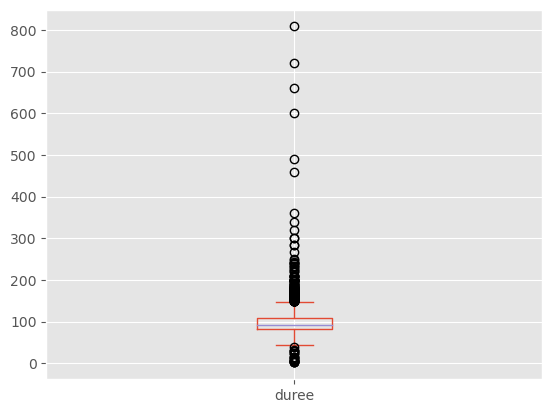

In [25]:
movie_df['duree'].plot(kind='box')

<Axes: >

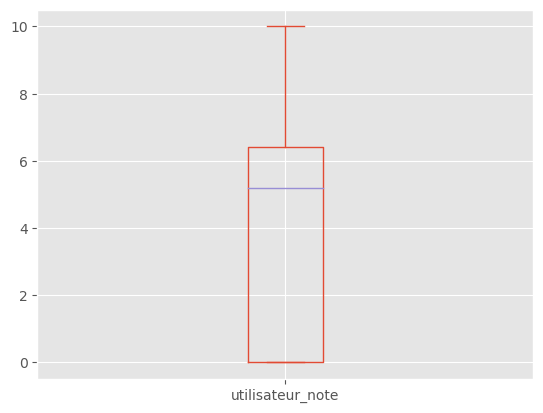

In [26]:
movie_df['utilisateur_note'].plot(kind='box')

<Axes: >

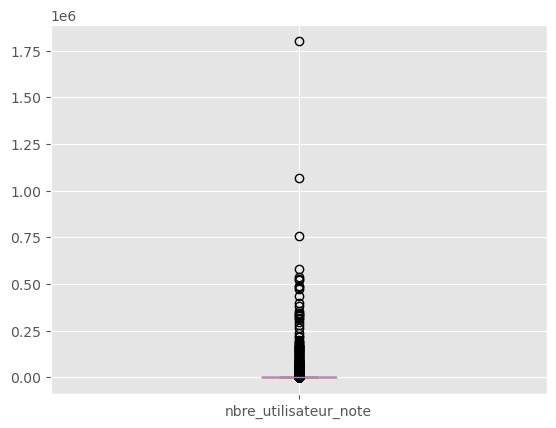

In [27]:
movie_df['nbre_utilisateur_note'].plot(kind='box')

In [28]:
# Fonction d'élimination des valeurs aberrantes
def remove_outliers(column_name, dataframe):
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1
    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    outliers = (dataframe[column_name] > max_value) | (dataframe[column_name] < min_value)
    dataframe = dataframe.loc[~outliers, :]

    return dataframe

# Éliminer les valeurs aberrantes des colonnes "duree", "utilisateur_note" et "nbre_utilisateur_note"
movie_df = remove_outliers("duree", movie_df)
movie_df = remove_outliers("utilisateur_note", movie_df)
movie_df = remove_outliers("nbre_utilisateur_note", movie_df)

In [29]:
movie_df.describe().T

count                           mean  \
utilisateur_note       7924.0                       3.880931   
duree                  7924.0                      92.400429   
nbre_utilisateur_note  7924.0                     105.861307   
date_sortie              7924  2017-12-31 23:59:59.999999744   

                                       min                  25%  \
utilisateur_note                       0.0                  0.0   
duree                                 45.0                 80.0   
nbre_utilisateur_note                  0.0                  0.0   
date_sortie            2018-01-01 00:00:00  2018-01-01 00:00:00   

                                       50%                  75%  \
utilisateur_note                       4.9                  6.3   
duree                                 90.0                104.0   
nbre_utilisateur_note                 23.0                128.0   
date_sortie            2018-01-01 00:00:00  2018-01-01 00:00:00   

                                       max         std  
utilisateur_note                      10.0    2.945898  
duree                                148.0   21.076106  
nbre_utilisateur_note                831.0  172.594601  
date_sortie            2018-01-01 00:00:00         NaN

### Créer une colonne pour chaque genre. Il ne faut laisser que les 5 genres les plus cités et regrouper le reste dans une colonne autres genres.

* Premièrement on va rechercher les 5 genres les plus cités

In [30]:
genre_counts = movie_df['genres_liste'].str.split(expand=True).stack().value_counts() 
#genre_counts
genre_counts.head(5)

Drama       4031
Comedy      2001
Thriller     893
Horror       834
Romance      771
Name: count, dtype: int64

**NOTE** les genres le plus representer sont: <br>
    1.Drama
    2. Comedy
    3. Horror
    4. Thriller
    5. Action
    

In [31]:
# List of genres to keep
allowed_genres = ['Drama', 'Comedy', 'Horror', 'Thriller', 'Action']

# Create a boolean mask for values not in the allowed genres
mask = ~movie_df['genres_liste'].isin(allowed_genres)

# Replace values not in the allowed genres with 'Autre_genre'
movie_df.loc[mask, 'genres_liste'] = 'Autre_genre'


In [32]:
movie_df['genres_liste'].value_counts()

genres_liste
Autre_genre    4191
Drama          2142
Comedy          766
Horror          358
Thriller        292
Action          175
Name: count, dtype: int64

In [33]:
# Creation de la colone Drama
drama_mapping = {'Autre_genre':0,'Drama':1,'Comedy':0,'Horror':0,'Thriller':0, 'Action':0}
movie_df['drama'] = movie_df['genres_liste'].map(drama_mapping)

# pour la colonne Comedy
drama_mapping = {'Autre_genre':0,'Drama':0,'Comedy':1,'Horror':0,'Thriller':0, 'Action':0}
movie_df['comedy'] = movie_df['genres_liste'].map(drama_mapping)

# pour la colonne Horror
drama_mapping = {'Autre_genre':0,'Drama':0,'Comedy':0,'Horror':1,'Thriller':0, 'Action':0}
movie_df['horror'] = movie_df['genres_liste'].map(drama_mapping)

# pour la colonne Thriller
drama_mapping = {'Autre_genre':0,'Drama':0,'Comedy':0,'Horror':0,'Thriller':1, 'Action':0}
movie_df['thriller'] = movie_df['genres_liste'].map(drama_mapping)


# pour la colonne Action
drama_mapping = {'Autre_genre':0,'Drama':0,'Comedy':0,'Horror':0,'Thriller':0, 'Action':1}
movie_df['action'] = movie_df['genres_liste'].map(drama_mapping)

# pour la colonne Autre genre
drama_mapping = {'Autre_genre':1,'Drama':0,'Comedy':0,'Horror':0,'Thriller':0}
movie_df['autre_genre'] = movie_df['genres_liste'].map(drama_mapping)

In [34]:
# On suprime la variable genres_liste maintenant vu qu'on a crée les genres pour les elements le plus representer.
movie_df.drop('genres_liste',axis=1, inplace=True)

In [35]:
movie_df.dtypes

titre_film                       object
utilisateur_note                float64
duree                             int64
nbre_utilisateur_note           float64
date_sortie              datetime64[ns]
drama                             int64
comedy                            int64
horror                            int64
thriller                          int64
action                            int64
autre_genre                     float64
dtype: object

## **2. Creer 2 nouvelles colonnes durée minutes log, nbre utilisateur note log.**

### Pour la variable nbre_utilisateur_note_log

In [36]:
movie_df['nbre_utilisateur_note_log'] = np.log(movie_df['nbre_utilisateur_note'])

In [37]:
movie_df['nbre_utilisateur_note_log']

102      5.811141
258      3.218876
259      5.940171
280      5.411646
297      3.891820
           ...   
12902    4.795791
12903        -inf
12904        -inf
12905        -inf
12906        -inf
Name: nbre_utilisateur_note_log, Length: 7924, dtype: float64

### Pour la variable duree_minutes_log

In [38]:
movie_df['duree_minutes_log'] = np.log(movie_df['duree'])

In [39]:
movie_df['duree_minutes_log']

102      4.454347
258      4.510860
259      4.290459
280      4.488636
297      4.634729
           ...   
12902    4.382027
12903    4.787492
12904    3.951244
12905    4.382027
12906    3.951244
Name: duree_minutes_log, Length: 7924, dtype: float64

## 3. Réaliser une analyse univariée complète avec les visualisations adéquate et interpréter les résultats
Pour commencer, nous allons revoir les types de nos différentes variables

In [40]:
movie_df.head(2).T

102                  258
titre_film                 Strangeways Here We Come  Virndavani Vairagya
utilisateur_note                                5.1                  6.6
duree                                            86                   91
nbre_utilisateur_note                         334.0                 25.0
date_sortie                     2018-01-01 00:00:00  2018-01-01 00:00:00
drama                                             0                    1
comedy                                            0                    0
horror                                            0                    0
thriller                                          0                    0
action                                            0                    0
autre_genre                                     1.0                  0.0
nbre_utilisateur_note_log                  5.811141             3.218876
duree_minutes_log                          4.454347              4.51086

**Note:** Dans notre jeu de données, nous avons:
* 8 variables catégorielles (titre_film, date_sortie, drama, comedy, horror, thriller, action, autre_genre), les deux premières seront exclues de l'analyse;
* et 5 autres de types numériques (utilisateur_note, duree, nbre_utilisateur_note, nbre_utilisateur_note_log, duree_minutes_log), seulement les 3 premiers vont être considérées pour l'analyse.

#### Analyse univariée pour les variables numériques (utilisateur_note, duree, nbre_utilisateur_note)

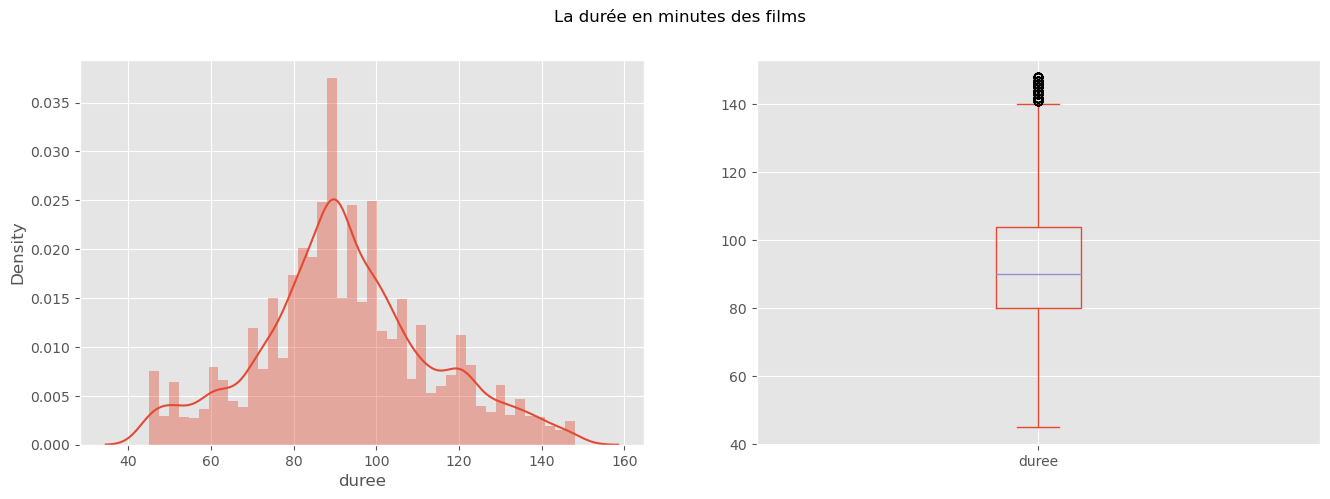

In [41]:
#durée
plt.figure(1)
plt.subplot(121)
sns.distplot(movie_df["duree"])

plt.subplot(122)
movie_df["duree"].plot.box(figsize=(16,5))

plt.suptitle("La durée en minutes des films")
plt.show()

**Interprétation des graphiques:** A partir de ces graphiques nous pouvons lire
* La durée des films suivent une distribution presque normale.<br>
* La durée moyenne de chaque film est de 90min (càd 1h30min)<br>
* Quelques rares films durent plus de 140min

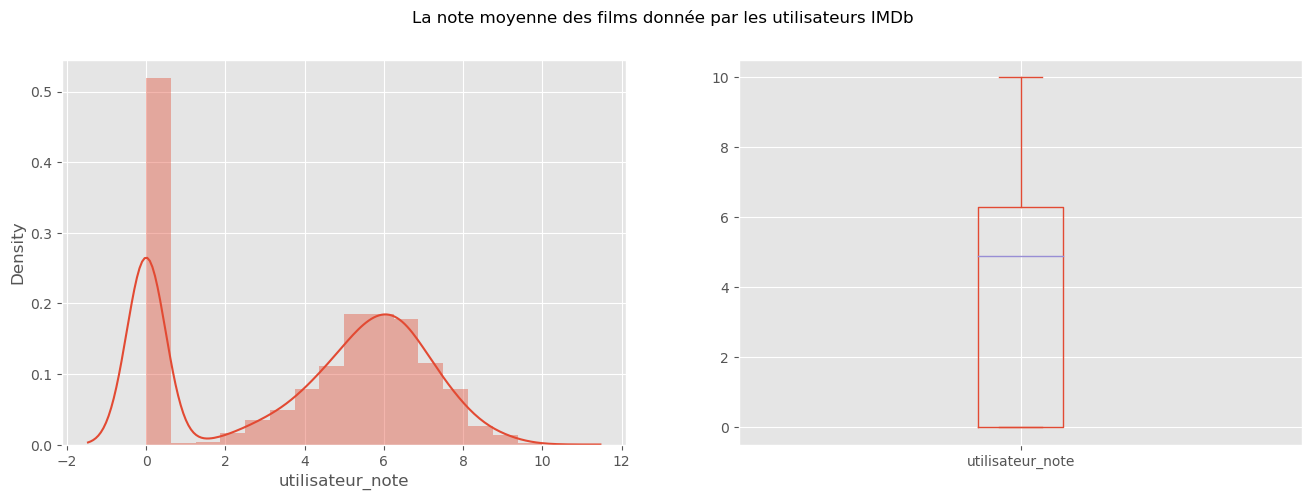

In [42]:
#utilisateur_note
plt.figure(1)
plt.subplot(121)
sns.distplot(movie_df["utilisateur_note"])

plt.subplot(122)
movie_df["utilisateur_note"].plot.box(figsize=(16,5))

plt.suptitle("La note moyenne des films donnée par les utilisateurs IMDb")
plt.show()

**Interprétation des graphiques:** <br>
* Le premier graphique montre que les notes attribuées aux films suivent une distribution normale de type bimodale <br>
* la première modalité indique la plupart des films ont obtenu la note zéro (ou n'ont pas du tout été noté), <br>
* l'autre modalité indique une distribution normale symétrique centrée autour de la moyenne 6.
                                                 

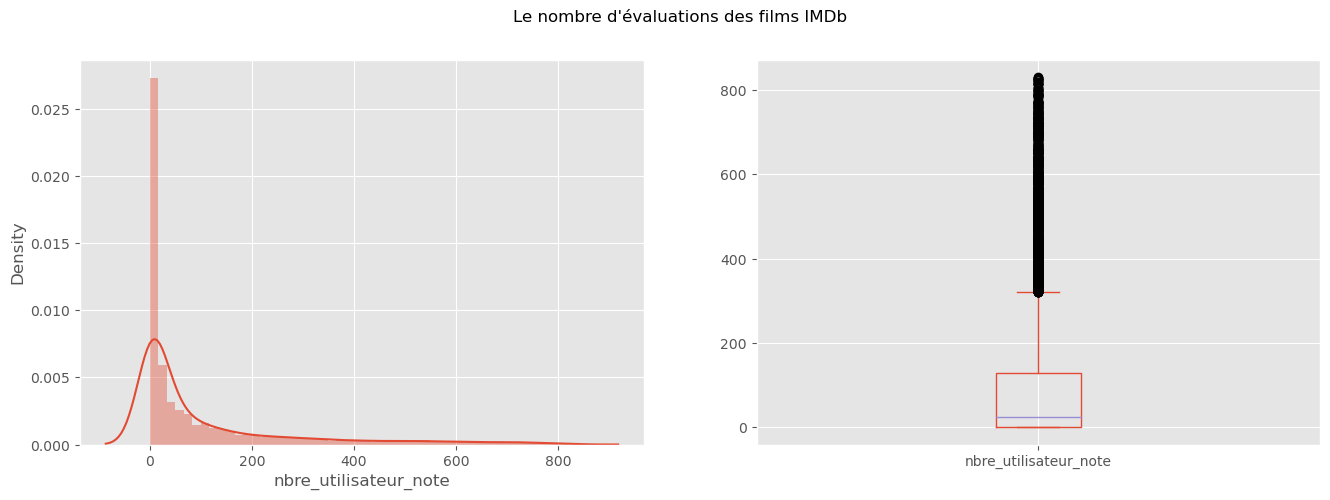

In [43]:
#nbre_utilisateur_note
plt.figure(1)
plt.subplot(121)
sns.distplot(movie_df["nbre_utilisateur_note"])

plt.subplot(122)
movie_df["nbre_utilisateur_note"].plot.box(figsize=(16,5))

plt.suptitle("Le nombre d'évaluations des films IMDb")
plt.show()

**Interprétation des graphiques:** Sur le premier graphique, nous remarquons une distribution normale asymétrique à droite.

#### Analyse univariée pour les variables catégorielles
Variables concernées : drama, comedy, horror, thriller, action, autre_genre

<Axes: title={'center': 'Le Genre: Drama'}, xlabel='drama'>

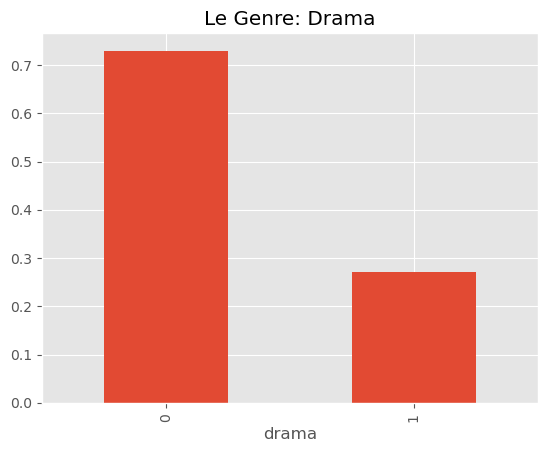

In [44]:
movie_df["drama"].value_counts()
movie_df["drama"].value_counts(normalize=True)*100
movie_df["drama"].value_counts(normalize=True).plot.bar(title="Le Genre: Drama")

**Interprétation du graphique:** Les films dramatiques (Drama) sont les plus représentés avec 25% de l'ensemble des films.

<Axes: title={'center': 'Le Genre: Comedy'}, xlabel='comedy'>

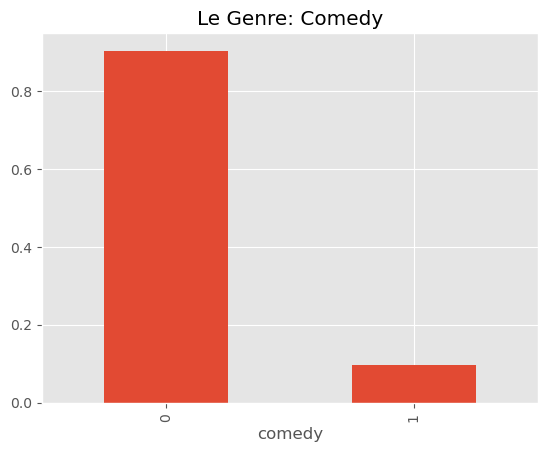

In [45]:
movie_df["comedy"].value_counts()
movie_df["comedy"].value_counts(normalize=True)*100
movie_df["comedy"].value_counts(normalize=True).plot.bar(title="Le Genre: Comedy")

**Interprétation du graphique:** Les films Comedy representent 10% des films du dataset.

<Axes: title={'center': 'Le Genre: Horror'}, xlabel='horror'>

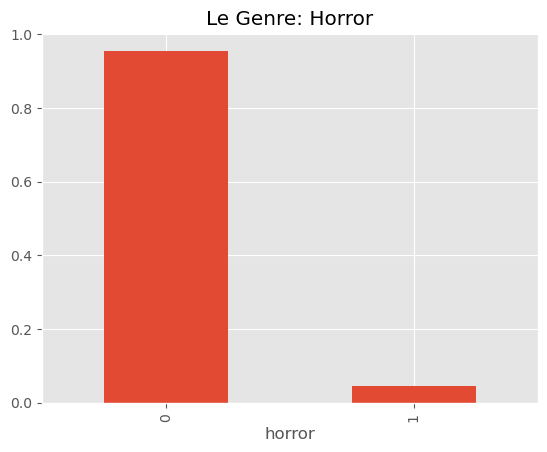

In [46]:
movie_df["horror"].value_counts()
movie_df["horror"].value_counts(normalize=True)*100
movie_df["horror"].value_counts(normalize=True).plot.bar(title="Le Genre: Horror")

**Interprétation du graphique:** Les films d'horreur possèdent une representativité d'environ 5%.

<Axes: title={'center': 'Le Genre: Thriller'}, xlabel='thriller'>

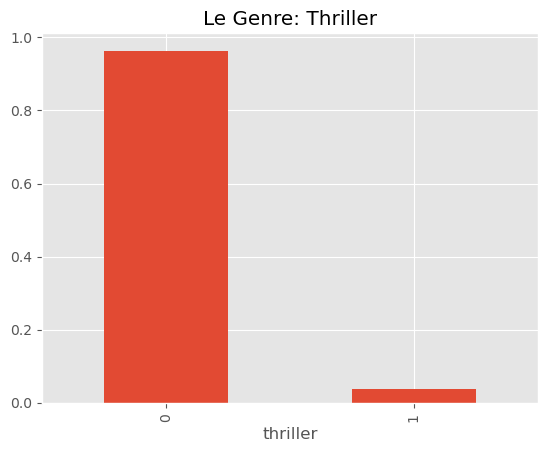

In [47]:
movie_df["thriller"].value_counts()
movie_df["thriller"].value_counts(normalize=True)*100
movie_df["thriller"].value_counts(normalize=True).plot.bar(title="Le Genre: Thriller")

**Interprétation du graphique:** Les films Thriller representent près de 5% des films du jeux de données.

<Axes: title={'center': 'Le Genre: Action'}, xlabel='action'>

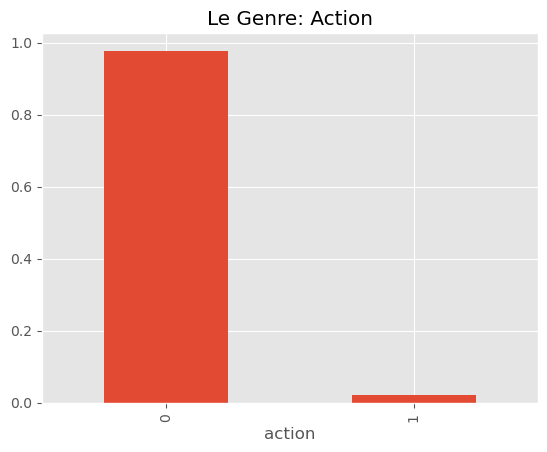

In [48]:
movie_df["action"].value_counts()
movie_df["action"].value_counts(normalize=True)*100
movie_df["action"].value_counts(normalize=True).plot.bar(title="Le Genre: Action")

**Interprétation du graphique:** Les films d'actions represent quelques 4% de l'ensemble des genres.

<Axes: title={'center': 'Le Genre: autre_genre'}, xlabel='autre_genre'>

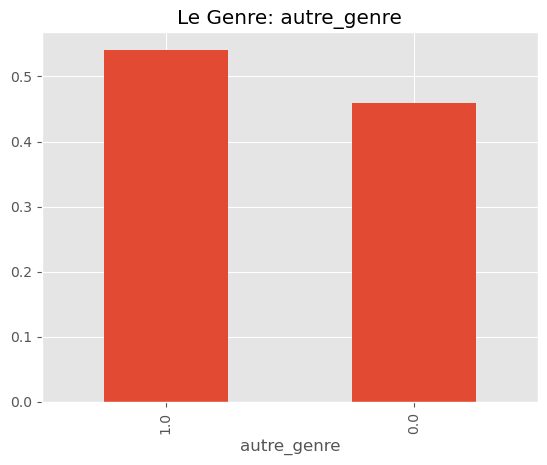

In [49]:
movie_df["autre_genre"].value_counts()
movie_df["autre_genre"].value_counts(normalize=True)*100
movie_df["autre_genre"].value_counts(normalize=True).plot.bar(title="Le Genre: autre_genre")

**Interprétation du graphique:** les autres genres represent environ 45% des films de notre dataset.

## 4. Réaliser une analyse bivariée complete avec les visualisations adéquates et interpréter les résultats.

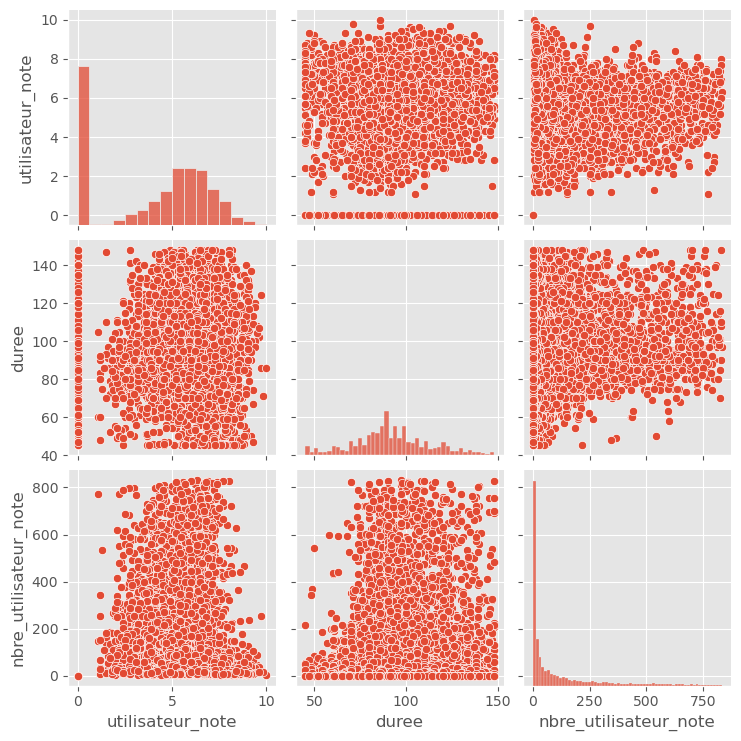

In [50]:
sns.pairplot(movie_df[['utilisateur_note', 'duree', 'nbre_utilisateur_note']])

Le graphique ci-dessus, montre la corrélation entre les trois variables utilisateur_note, duree et nbre_utilisateur_note. On peut déduire qu'aucune d'entre elles n'est corrélée aux autres.

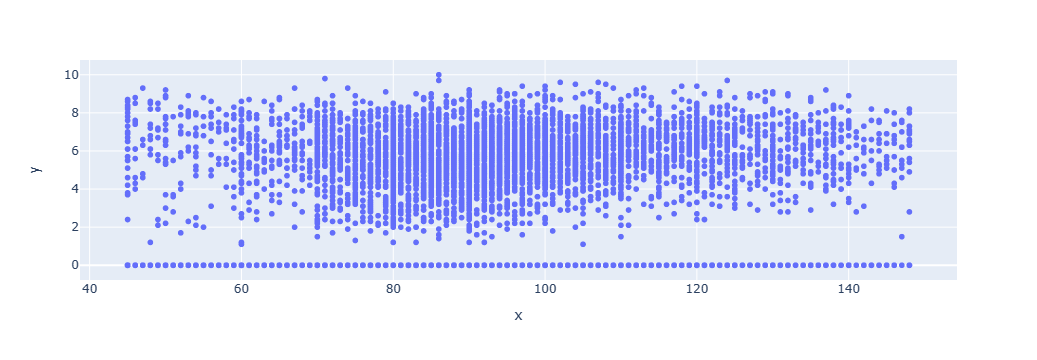

In [51]:
import plotly.express as px

px.scatter(x = movie_df['duree'], y = movie_df['utilisateur_note'])

Ce graphique nous montre que, malgré la transformation (standardisation) de la variable utilisateur_note grâce à la fonction log, les deux variables ne sont pas corrélées. Car la corrélation évolue selon un sens uniforme.

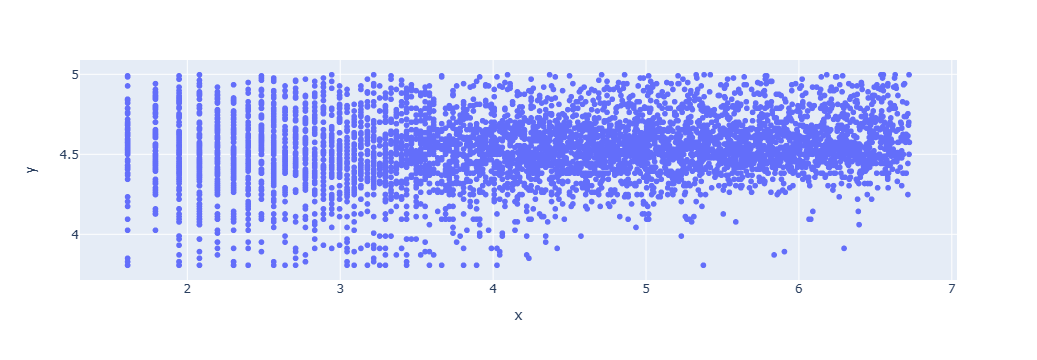

In [52]:
px.scatter(x=movie_df['nbre_utilisateur_note_log'], y=movie_df['duree_minutes_log'])

Cet autre graphique montre un comportement similaire que le précédent, les variables *nbre_utilisateur_note_log* et *duree_minutes_log* ne sont pas corrélées.

## 5. Dans cette question, on s’intéresse à prédire la note d’un film utilisateur note en fonction de 6 colonnes nbre utilisateur note log, durée minutes log, drame, action, thriller, et horreur. Concevez un modèle de régression linéaire qui permet de faire cette prédiction, vérifier les 4 conditions nécessaires pour appliquer la régression linéaire et évaluer votre modèle.



In [53]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer

#precision, absolute error, squared error, root squared error

In [54]:
X = movie_df[['nbre_utilisateur_note_log', 'duree_minutes_log', 'drama', 'action', 'thriller', 'horror']]

# Target
y = movie_df['utilisateur_note']

Ici on va essayer de voir la correlation entre la variable **utilisateur_note** et les variables independante.

In [55]:
movie_df[['nbre_utilisateur_note_log', 'duree_minutes_log', 'drama', 'action', 'thriller', 'horror', 'utilisateur_note']]\
            .corr()['utilisateur_note']

nbre_utilisateur_note_log   -0.228866
duree_minutes_log            0.189819
drama                        0.006101
action                      -0.042493
thriller                    -0.006466
horror                      -0.033266
utilisateur_note             1.000000
Name: utilisateur_note, dtype: float64

**NOTE:** Apres avoir utliser log transformation on constate que certains valeur n'as puis se converture vu que c'est de grande valeurs donc il se sont transformer en infnie. Raison pour la quelle il faut suprimer les infinie pour pouvoir entrainer le modele.

In [56]:
X = X[np.isfinite(X).all(1)]
y = y[:len(X)]

y.shape, X.shape

((5352,), (5352, 6))

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

In [58]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [59]:
y_pred = model.predict(X_test)

In [60]:
metrics.r2_score(y_test, y_pred)

0.009248531430388618

In [61]:
metrics.mean_squared_error(y_test, y_pred)

5.3755414102237715

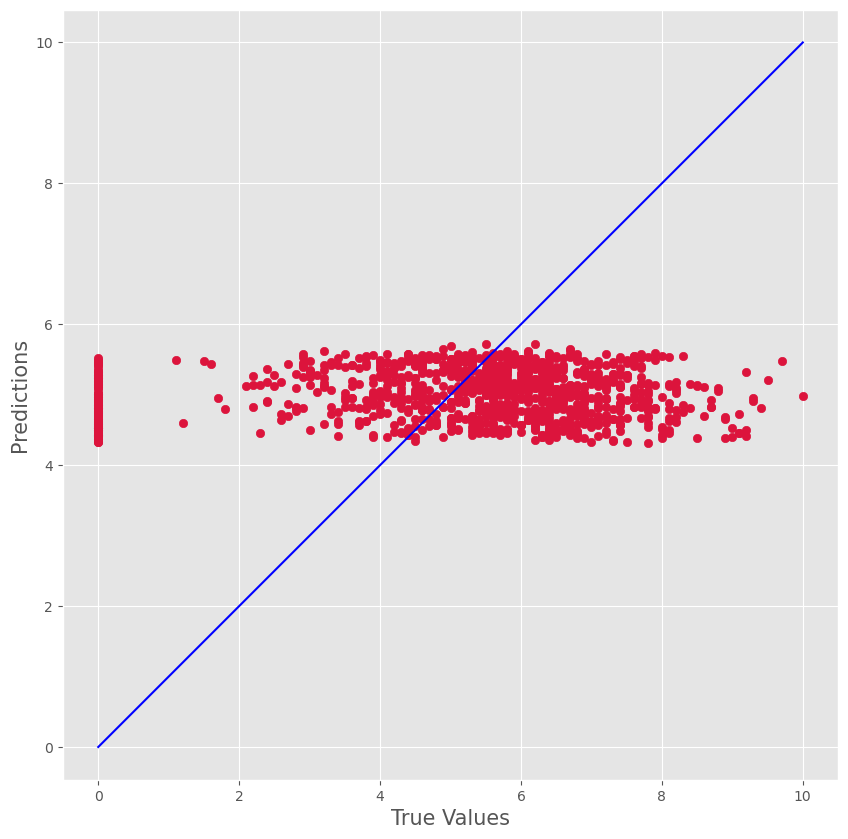

In [62]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

#### * Vérification des quatres conditions d'applications de la regression linéaire

Text(0, 0.5, 'y_pred')

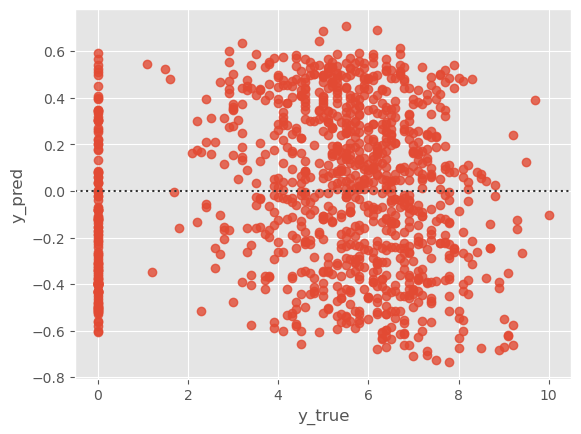

In [63]:
sns.residplot(x=y_test, y=y_pred)
plt.xlabel('y_true')
plt.ylabel('y_pred')

## 6. Refaire la question précedente après avoir effectuer une normalisation adéquate. Comparer les résutlats.
Remarques: Pour les deux dernières questions, on garde 80% des données pour l’entraˆınement et le reste pour les tests.


### Normalization de X

In [64]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [70]:
scaler = StandardScaler()

X_scale = scaler.fit_transform(X)
#X_scale

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)

In [72]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [73]:
y_pred_lr = lr.predict(X_test)

In [74]:
r2 = metrics.r2_score(y_test, y_pred_lr)
r2

0.009248531430388618

**Note:** Les deux modèles affichent le même score, ce qui indique que la normalisation des données n'a pas réussi à améliorer les performances comme prévu.